In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [2]:
from functions import *

In [3]:
from algorithms_comp import *

In [4]:
from utils import *

# Logistic regression

## a9a

In [5]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  768 , dimension of the problem:  8
Smoothness constant of the sum:  8606.92253909742
Average smoothness constant   :  10862.250377252869
Worst smoothness constant     :  189988.542101
Fraction of non-zero elemenst :  0.8758138020833334
CPU times: total: 31.2 ms
Wall time: 5 ms


### Find the solution

In [6]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [7]:
%%time
param = [A, y, l2, False]
res_solver = minimize(logreg_loss, x_init, args = param, jac=logreg_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.6084979240101024
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.6084979240101024
        x: [-1.284e-01 -1.294e-02  3.033e-02 -1.956e-04 -7.389e-04
             4.814e-03 -3.203e-01  1.563e-02]
      nit: 84
      jac: [-1.617e-06  2.453e-05  2.518e-05  1.565e-05  6.906e-05
             1.449e-05  3.192e-07  1.009e-05]
     nfev: 101
     njev: 101
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 15.6 ms
Wall time: 21 ms


In [8]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Parameters

In [9]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 10

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 50.0
x_init[0:num_of_non_zeros] += shift_param
N = 1000

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-3
param = [logreg_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", logreg_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  84.41785429261023


# Tests

### ARDFDS_E

In [10]:
# %%time
# tuning_stepsize_param_options_ardfds_e = [1.0, 2.0]
# for step_param in tuning_stepsize_param_options_ardfds_e:
#     ardfds_e_res[i] = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N, 
#                         f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
#     print("Finished with stepsize parameter = ", step_param)

In [11]:
zo_accsgd_res = zo_accsgd_stoch(filename, x_init, args=param, bs=bs, N=N, f_star=f_star, x_star=x_star, tuning_stepsize_param=1.0)

5.208333333333333 0.000605133055360286


In [12]:
ardfds_e_res = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N, f_star=f_star, x_star=x_star, tuning_stepsize_param=1.0)
# zo_accsgd_res = zo_accsgd(filename, x_init, args=param, bs=bs, N=N, f_star=f_star, x_star=x_star, tuning_stepsize_param=1.0)

In [13]:
zo_varag_res = zo_varag(filename, x_init, args=param, bs=bs, N=N, f_star=f_star, x_star=x_star, tuning_stepsize_param=1.0)

(8, 8)


ValueError: operands could not be broadcast together with shapes (10,8) (10,) 

In [ ]:
def comp_plot(zo_accsgd_res, ardfds_e_res):
    fig, ax = plt.subplots(figsize=(14, 10))
    # plt.title(r"")
    ax.set_ylabel(r"Loss, $f(x) - f(x*)$", fontsize=40)
    ax.set_xlabel(r"Iterations", fontsize=40)
    # ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=30)

    plt.plot(zo_accsgd_res['iters'], zo_accsgd_res['func_vals'], color='navy', linestyle='-',    label=f'ZO-AccSGD')
    plt.plot(ardfds_e_res['iters'], ardfds_e_res['func_vals'], color='crimson', linestyle='-',    label=f'ARDFDS')
    
    ax.legend(loc='best', prop={'size': 35})
    ax.grid(which='major', color='#DDDDDD', linewidth=1)
    # ax.grid(which='minor', color='#CCCCCC', linestyle=':', linewidth=0.8)
    # ax.minorticks_on()
    plt.tight_layout()

    plt.savefig(f'approx_comp_3.pdf')

    plt.show()

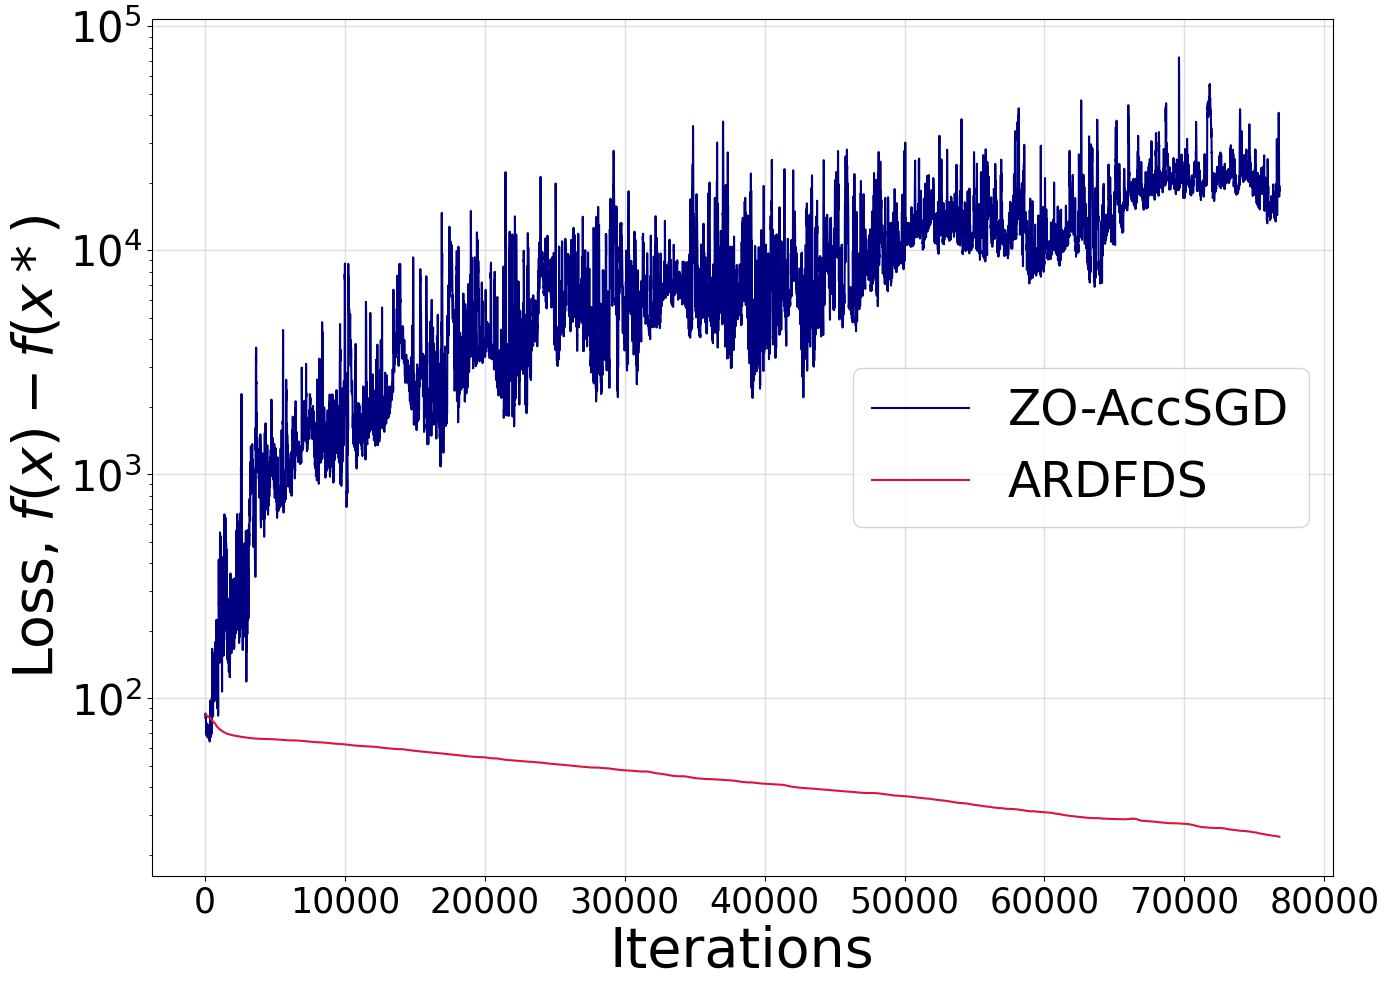

In [ ]:
comp_plot(zo_accsgd_res, ardfds_e_res)

In [ ]:
# methods = np.array(['ARDFDS_E logreg', 0.1, N, delta, bs, "ARDFDS_E "+str(0.1), None])
# tuning_stepsize_param_options_ardfds_e = [0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
# for i in range(1,len(tuning_stepsize_param_options_ardfds_e)):
#     methods = np.vstack((methods, 
#                          np.array(['ARDFDS_E logreg', tuning_stepsize_param_options_ardfds_e[i], N, delta, bs, 
#                           "ARDFDS_E "+str(tuning_stepsize_param_options_ardfds_e[i]), None])))
#     print(methods)

# mode_y = 'func_vals'
# mode_x = 'oracle_calls'
# figsize = (12, 8)
# title_size = 30
# linewidth = 2
# markersize = 20
# legend_size = 20
# xlabel_size = 30
# ylabel_size = 40
# xticks_size = 30
# yticks_size = 30
# sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
# title = dataset+r", $M = $"+str(m)+r", $n = $"+str(n)+r", $m = $"+str(bs)
# bbox_to_anchor = (1,1)
# legend_loc="upper right"

# save_fig = [True, filename+"_ardfds_e_noise_tuning_stepsize_"+"_delta_"+str(delta)
#             +"_batch_"+str(m)+".pdf"]

# args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
# make_plots(args_for_plots)